<a href="https://colab.research.google.com/github/meashu31/AIML-Capstone-CV9/blob/Vadhi_master/Unet_Model_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Gogle Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load necessary libraries

In [3]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
import os
from keras import backend as K
import keras
from keras.utils.data_utils import Sequence
from tensorflow.python.keras.utils import data_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import pickle
import feather
from sklearn.metrics import accuracy_score
%matplotlib inline

Using TensorFlow backend.


## Set working directory

In [4]:
path = '/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/'
os.chdir(path) #changing the current directory path to the project direcotry where the dataset is available
path = os.getcwd() # directory path of all the images

In [5]:
im_path = path +'/data/image_data/images/'
mask_path = path + '/data/mask_data/masks/'
train_list = os.listdir(im_path)
mask_list = os.listdir(mask_path)
print('Number of train Images:',len(train_list),'\nNumber of Mask Images:',len(mask_list))
# Check for any name mismatch between images and masks
print("Number of UnCommon Images",list(set(train_list) - set(mask_list)))

Number of train Images: 26684 
Number of Mask Images: 26684
Number of UnCommon Images []


In [6]:
image_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,validation_split=0.2,zoom_range=0.2)
mask_gen_args = dict(featurewise_center=True,rotation_range=90,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,validation_split=0.2,rescale=1./255,zoom_range=0.2)

image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)
seed = 1

image = tf.keras.preprocessing.image.load_img(im_path+train_list[0])
input_img = keras.preprocessing.image.img_to_array(image)
input_img = np.array([input_img])  # Convert single image to a batch.

print("Input image shape:",input_img.shape)

mask = tf.keras.preprocessing.image.load_img(mask_path+train_list[0], color_mode="grayscale")
input_mask = keras.preprocessing.image.img_to_array(mask,)
input_mask = np.array([input_mask])  # Convert single image to a batch.
print("Input mask shape:",input_mask.shape)

image_datagen.fit(input_img, augment=True, seed=seed)
mask_datagen.fit(input_mask, augment=True, seed=seed)

Input image shape: (1, 1024, 1024, 3)
Input mask shape: (1, 1024, 1024, 1)


In [7]:
#------------------------- Train DataSetGenerator -------------------------#
train_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='training',seed=seed)
train_mask_generator = mask_datagen.flow_from_directory("data/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=4,shuffle=True,subset='training',seed=seed)
#------------------------- Validation DataSetGenerator -------------------------#
validation_image_generator = image_datagen.flow_from_directory("data/image_data",class_mode=None,color_mode="rgb",target_size=(224,224),batch_size=4,shuffle=True,subset='validation',seed=seed)
validation_mask_generator = mask_datagen.flow_from_directory("data/mask_data",class_mode=None,color_mode="grayscale",target_size=(224,224),batch_size=4,shuffle=True,subset='validation',seed=seed)

Found 21348 images belonging to 1 classes.
Found 21348 images belonging to 1 classes.
Found 5336 images belonging to 1 classes.
Found 5336 images belonging to 1 classes.


## Parameter list for the model

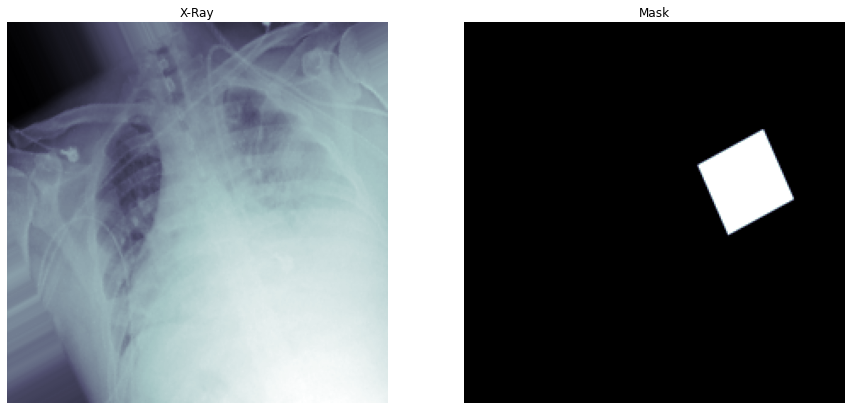

In [8]:
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))
ax1.imshow(train_image_generator[1][0][:,:,0], cmap = plt.cm.bone)
ax1.set_title('X-Ray')
ax1.axis('off')
ax2.imshow(train_mask_generator[1][0][:,:,0], cmap = plt.cm.bone)
ax2.set_title('Mask')
ax2.axis('off')
plt.show()

In [9]:
train_generator = zip(train_image_generator, train_mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)

In [10]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [11]:
include_top = False
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
weights = "imagenet"

In [12]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

In [13]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=include_top, alpha=ALPHA, weights=weights)
    for layer in model.layers:
        layer.trainable = trainable
        # Add all the UNET layers here
        relu_1 = model.get_layer("conv_pw_1_relu").output
        relu_3 = model.get_layer("conv_pw_3_relu").output
        relu_5 = model.get_layer("conv_pw_5_relu").output
        relu_11 = model.get_layer("conv_pw_11_relu").output
        relu_13 = model.get_layer("conv_pw_13_relu").output

        x = Concatenate()([UpSampling2D()(relu_13), relu_11])
        x = Concatenate()([UpSampling2D()(x), relu_5])
        x = Concatenate()([UpSampling2D()(x), relu_3])
        x = Concatenate()([UpSampling2D()(x), relu_1])
        x = UpSampling2D()(x)
        #Used Relu 13,11,5,3,1 and upsamplings to get back 224*224 size
        x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
        x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

In [14]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
#model = create_model()
# Print summary
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

## Define metrics, loss and optimizers

In [15]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [16]:
def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [23]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=jaccard_distance_loss, optimizer=optimizer, metrics=[[tf.keras.metrics.BinaryAccuracy(),iou_loss_core]])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
filepath = "/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_MobileNet_Weights/"

checkpoint = ModelCheckpoint(filepath+"model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

## Fit the model on the training set

In [25]:
batch_size = 4
model.fit(train_generator,
          epochs=1,
          use_multiprocessing=True,
          workers = 15,
          steps_per_epoch = 21348//(batch_size**2),
          validation_data=validation_generator,
          validation_steps = 5336//(batch_size**2),
          callbacks= [checkpoint, reduce_lr, stop])

1334/1334 [==============================] - ETA: 0s - loss: 2.3957 - binary_accuracy: 0.9808 - iou_loss_core: 0.9230WARNING:tensorflow:Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `tf.data.Dataset`.

Epoch 00001: loss improved from inf to 2.39574, saving model to /content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_MobileNet_Weights/model-2.40.h5
1334/1334 [==============================] - 7164s 5s/step - loss: 2.3957 - binary_accuracy: 0.9808 - iou_loss_core: 0.9230 - val_loss: 5.3102 - val_binary_accuracy: 0.9566 - val_iou_loss_core: 0.8537 - lr: 1.0000e-04


## Load the model from checkpoint for testing

In [28]:
WEIGHTS_FILE = "/content/drive/My Drive/great learning/capstone project/rsna-pneumonia-detection/UNet_MobileNet_Weights/model-2.40.h5"
THRESHOLD = 0.8
EPSILON = 0.02

# model = create_model()
model = create_model()
model.load_weights(WEIGHTS_FILE)

## Create a test generator

In [29]:
test_list = ['0a2c130c-c536-4651-836d-95d07e9a89cf.png','0a03fbf6-3c9a-4e2e-89ce-c7629ae43a27.png']
#test_gen = DataGenerator(list_IDs=test_list , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)

## Prepare image for the model input

In [32]:
n = 0
sample_image = test_gen[n][0][0]
sample_image_redim = np.expand_dims(sample_image, axis=0)

NameError: ignored

## Pass image to the predict function

In [ ]:
region = model.predict(sample_image_redim)

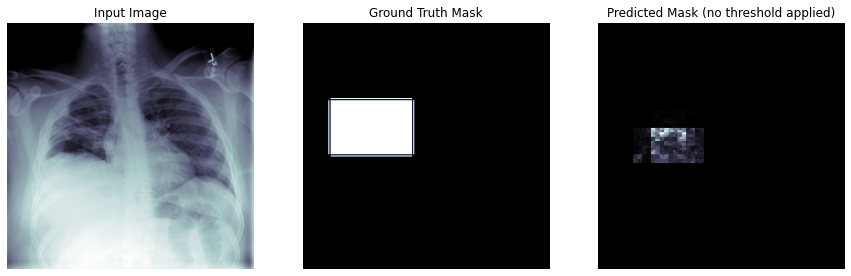

In [ ]:
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))
ax1.imshow(sample_image[:,:,0], cmap = plt.cm.bone)
ax1.set_title('Input Image')
ax1.axis('off')
ax2.imshow(test_gen[n][1][0], cmap = plt.cm.bone)
ax2.set_title('Ground Truth Mask')
ax2.axis('off')
ax3.imshow(region[0], cmap = plt.cm.bone)
ax3.set_title('Predicted Mask (no threshold applied)')
ax3.axis('off')
plt.show()